In [13]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import random
from abc import abstractmethod
from tensorflow.keras.applications import VGG16
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
import pandas as pd

### Data Augmentation

#### Random resized crop

In [14]:
# crops and resizes part of the image to the original resolutions
class RandomResizedCrop(layers.Layer):
    def __init__(self, scale, ratio, **kwargs):
        super().__init__(**kwargs)
        # area-range of the cropped part: (min area, max area), uniform sampling
        self.scale = scale
        # aspect-ratio-range of the cropped part: (log min ratio, log max ratio), log-uniform sampling
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]
            height = tf.shape(images)[1]
            width = tf.shape(images)[2]

            # independently sampled scales and ratios for every image in the batch
            random_scales = tf.random.uniform(
                (batch_size,), self.scale[0], self.scale[1]
            )
            random_ratios = tf.exp(
                tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
            )

            # corresponding height and widths, clipped to fit in the image
            new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
            new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)

            # random anchors for the crop bounding boxes
            height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
            width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

            # assemble bounding boxes and crop
            bounding_boxes = tf.stack(
                [
                    height_offsets,
                    width_offsets,
                    height_offsets + new_heights,
                    width_offsets + new_widths,
                ],
                axis=1,
            )
            images = tf.image.crop_and_resize(
                images, bounding_boxes, tf.range(batch_size), (height, width)
            )

        return images

#### Random color jitter

In [15]:
# distorts the color distibutions of images
class RandomColorJitter(layers.Layer):
    def __init__(self, brightness, contrast, saturation, hue, **kwargs):
        super().__init__(**kwargs)

        # color jitter ranges: (min jitter strength, max jitter strength)
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

        # list of applicable color augmentations
        self.color_augmentations = [
            self.random_brightness,
            self.random_contrast,
            self.random_saturation,
            self.random_hue,
        ]

        # the tf.image.random_[brightness, contrast, saturation, hue] operations
        # cannot be used here, as they transform a batch of images in the same way

    def blend(self, images_1, images_2, ratios):
        # linear interpolation between two images, with values clipped to the valid range
        return tf.clip_by_value(ratios * images_1 + (1.0 - ratios) * images_2, 0, 1)

    def random_brightness(self, images):
        # random interpolation/extrapolation between the image and darkness
        return self.blend(
            images,
            0,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.brightness, 1 + self.brightness
            ),
        )

    def random_contrast(self, images):
        # random interpolation/extrapolation between the image and its mean intensity value
        mean = tf.reduce_mean(
            tf.image.rgb_to_grayscale(images), axis=(1, 2), keepdims=True
        )
        return self.blend(
            images,
            mean,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.contrast, 1 + self.contrast
            ),
        )

    def random_saturation(self, images):
        # random interpolation/extrapolation between the image and its grayscale counterpart
        return self.blend(
            images,
            tf.image.rgb_to_grayscale(images),
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.saturation, 1 + self.saturation
            ),
        )

    def random_hue(self, images):
        # random shift in hue in hsv colorspace
        images = tf.image.rgb_to_hsv(images)
        images += tf.random.uniform(
            (tf.shape(images)[0], 1, 1, 3), (-self.hue, 0, 0), (self.hue, 0, 0)
        )
        # tf.math.floormod(images, 1.0) should be used here, however in introduces artifacts
        images = tf.where(images < 0.0, images + 1.0, images)
        images = tf.where(images > 1.0, images - 1.0, images)
        images = tf.image.hsv_to_rgb(images)
        return images

    def call(self, images, training=True):
        if training:
            # applies color augmentations in random order
            for color_augmentation in random.sample(self.color_augmentations, 4):
                images = color_augmentation(images)
        return images

### Data Loader

In [16]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, xData, yData, batch_size=16, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.X = xData
        self.Y = yData
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        return self.X[indexes]/255,self.Y[indexes]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

#### Contrastive accuracy and correlation accuracy

In [17]:
def update_contrastive_accuracy(features_1, features_2,contrastive_accuracy=None):
    # self-supervised metric inspired by the SimCLR loss

    # cosine similarity: the dot product of the l2-normalized feature vectors
    features_1 = tf.math.l2_normalize(features_1, axis=1)
    features_2 = tf.math.l2_normalize(features_2, axis=1)
    similarities = tf.matmul(features_1, features_2, transpose_b=True)

    # the similarity between the representations of two augmented views of the
    # same image should be higher than their similarity with other views
    batch_size = tf.shape(features_1)[0]
    contrastive_labels = tf.range(batch_size)
    contrastive_accuracy.update_state(
        tf.concat([contrastive_labels, contrastive_labels], axis=0),
        tf.concat([similarities, tf.transpose(similarities)], axis=0),
    )

def update_correlation_accuracy(features_1, features_2, correlation_accuracy=None):
    # self-supervised metric inspired by the BarlowTwins loss

    # normalization so that cross-correlation will be between -1 and 1
    features_1 = (
        features_1 - tf.reduce_mean(features_1, axis=0)
    ) / tf.math.reduce_std(features_1, axis=0)
    features_2 = (
        features_2 - tf.reduce_mean(features_2, axis=0)
    ) / tf.math.reduce_std(features_2, axis=0)

    # the cross correlation of image representations should be the identity matrix
    batch_size = tf.cast(tf.shape(features_1)[0],tf.float32)
    cross_correlation = (
        tf.matmul(features_1, features_2, transpose_a=True) / batch_size
    )

    feature_dim = tf.shape(features_1)[1]
    correlation_labels = tf.range(feature_dim)
    correlation_accuracy.update_state(
        tf.concat([correlation_labels, correlation_labels], axis=0),
        tf.concat([cross_correlation, tf.transpose(cross_correlation)], axis=0),
    )


#### Contrastive loss

In [18]:
def contrastive_loss(
    projections_1,
    projections_2,
    m_projections_1,
    m_projections_2,feature_queue,temperature
):
    # similar to the SimCLR loss, however it uses the momentum networks'
    # representations of the differently augmented views as targets
    projections_1 = tf.math.l2_normalize(projections_1, axis=1)
    projections_2 = tf.math.l2_normalize(projections_2, axis=1)
    m_projections_1 = tf.math.l2_normalize(m_projections_1, axis=1)
    m_projections_2 = tf.math.l2_normalize(m_projections_2, axis=1)

    similarities_1_2 = (
        tf.matmul(
            projections_1,
            tf.concat((m_projections_2, feature_queue), axis=0),
            transpose_b=True,
        )
        / temperature
    )
    similarities_2_1 = (
        tf.matmul(
            projections_2,
            tf.concat((m_projections_1, feature_queue), axis=0),
            transpose_b=True,
        )
        / temperature
    )

    batch_size = tf.shape(projections_1)[0]
    contrastive_labels = tf.range(batch_size)
    loss = keras.losses.sparse_categorical_crossentropy(
        tf.concat([contrastive_labels, contrastive_labels], axis=0),
        tf.concat([similarities_1_2, similarities_2_1], axis=0),
        from_logits=True,
    )

    # feature queue update
    feature_queue.assign(
        tf.concat(
            [
                m_projections_1,
                m_projections_2,
                feature_queue[: -(2 * batch_size)],
            ],
            axis=0,
        )
    )
    return loss


In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


#### Define hyperparameter

In [9]:
# hyperparameters
num_epochs = 30
temperature = 0.1
queue_size = 10000
momentum_coeff = 0.99


#### Define models

In [10]:
## Augmentation
contrastive_augmenter=keras.Sequential(
        [
            layers.Input(shape=(32, 32, 3)),
#             preprocessing.Rescaling(1 / 255),
            preprocessing.RandomRotation((-0.05,0.05)),
            RandomResizedCrop(scale=(0.8, 1.0), ratio=(3 / 4, 4 / 3)),
            RandomColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        ],
        name="contrastive_augmenter",
    )

## Encoder
# encoder= VGG16(include_top=False,weights=None,input_shape = (32,32,3), pooling="max")
# width = encoder.output_shape[1]

width = 128
encoder=keras.Sequential(
        [
            layers.Input(shape=(32, 32, 3)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )


## Projection
projection_head=keras.Sequential([layers.Input(shape=(width,)),
                                  layers.Dense(width, activation="relu"),
                                  layers.Dense(width),],name="projection_head",)

## Encoder clone
m_encoder = keras.models.clone_model(encoder)

## Projection clone
m_projection_head = keras.models.clone_model(projection_head)

## Feature queue
feature_dimensions = encoder.output_shape[1]
feature_queue = tf.Variable(tf.math.l2_normalize(
                            tf.random.normal(shape=(queue_size, feature_dimensions)), axis=1),
                            trainable=False,)



2022-12-05 08:01:15.274435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 08:01:15.275599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 08:01:15.587562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 08:01:15.588546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 08:01:15.589371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

### Define metrics

In [11]:
contrastive_optimizer = tf.keras.optimizers.Adam()
contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy()
correlation_accuracy = keras.metrics.SparseCategoricalAccuracy()

In [ ]:
for epoch in range(num_epochs):
    print("\nepoch {}/{}".format(epoch+1,num_epochs))
    contrastive_accuracy.reset_states()
    correlation_accuracy.reset_states()
    pb = tf.keras.utils.Progbar(len(trainDataloader),stateful_metrics=["c_loss","c_acc","r_acc"])
    for batch,data in enumerate(trainDataloader):
        images,_ = data
        augmented_images_1 = contrastive_augmenter(images)
        augmented_images_2 = contrastive_augmenter(images)
        with tf.GradientTape() as tape:
            features_1 = encoder(augmented_images_1)
            features_2 = encoder(augmented_images_2)
            projections_1 = projection_head(features_1)
            projections_2 = projection_head(features_2)
            m_features_1 = m_encoder(augmented_images_1)
            m_features_2 = m_encoder(augmented_images_2)
            m_projections_1 = m_projection_head(m_features_1)
            m_projections_2 = m_projection_head(m_features_2)
            loss = contrastive_loss(
                projections_1, projections_2, m_projections_1, m_projections_2,feature_queue)
        gradients = tape.gradient(
            loss,
            encoder.trainable_weights + projection_head.trainable_weights,
        )
        contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                encoder.trainable_weights + projection_head.trainable_weights,
            )
        )
        update_contrastive_accuracy(m_features_1, m_features_2)
        update_correlation_accuracy(m_features_1, m_features_2)


        # the momentum networks are updated by exponential moving average
        for weight, m_weight in zip(encoder.weights, m_encoder.weights):
            m_weight.assign(momentum_coeff * m_weight + (1 - momentum_coeff) * weight)
            
        for weight, m_weight in zip(projection_head.weights, m_projection_head.weights):
            m_weight.assign(momentum_coeff * m_weight + (1 - momentum_coeff) * weight)

        pb.update(batch,values=[
            ("c_loss",loss),
            ("c_acc", contrastive_accuracy.result()),
            ("r_acc", correlation_accuracy.result())
        ])

### Preparing supervised data

In [54]:
data_percent = 0.5
indices = np.arange(len(x_train))
np.random.shuffle(indices)

choosen_indices = indices[:int(data_percent*len(indices))]
trainLinearDataloader = DataGenerator(x_train[choosen_indices], y_train[choosen_indices], 
                                      batch_size = 512, shuffle = True)
testLinearDataloader = DataGenerator(x_test, y_test, 
                                      batch_size = 512, shuffle = True)

#### Metric and losses

In [55]:
probe_optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-3)
probe_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
probe_loss = tf.keras.losses.SparseCategoricalCrossentropy()

probe_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
probe_test_loss = tf.keras.losses.SparseCategoricalCrossentropy()

#### Linear Model

In [56]:
linear_probe=keras.Sequential(
    [
        layers.Input(shape=(width,)),
        layers.Dense(10,activation="softmax"),
    ],
    name="linear_probe",
)

#### Training

In [57]:
for epoch in range(num_epochs):
    print("\nepoch {}/{}".format(epoch+1,num_epochs))
    probe_accuracy.reset_states()
    pb = tf.keras.utils.Progbar(len(trainLinearDataloader),stateful_metrics=["c_loss","c_acc"])
    for batch,data in enumerate(trainLinearDataloader):
        images,labels = data
#         augmented_images_1 = contrastive_augmenter(images)
        with tf.GradientTape() as tape:
            # the momentum encoder is used here as it moves more slowly
            features = m_encoder(images)
            class_logits = linear_probe(features)
            loss = probe_loss(labels, class_logits)
            
        gradients = tape.gradient(loss, linear_probe.trainable_weights)
        probe_optimizer.apply_gradients(
            zip(gradients, linear_probe.trainable_weights)
        )
        probe_accuracy.update_state(labels, class_logits)
        pb.update(batch,values=[
            ("c_loss",loss),
            ("c_acc", probe_accuracy.result())])


epoch 1/30
46/48 [===========================>..] - ETA: 0s - c_loss: 2.3607 - c_acc: 0.1186
epoch 2/30
46/48 [===========================>..] - ETA: 0s - c_loss: 2.1689 - c_acc: 0.1760
epoch 3/30
46/48 [===========================>..] - ETA: 0s - c_loss: 2.0665 - c_acc: 0.2262
epoch 4/30
47/48 [============================>.] - ETA: 0s - c_loss: 2.0654 - c_acc: 0.2672- ETA: 0s - c_loss: 2.0151 - c_acc: 0.267
epoch 5/30
46/48 [===========================>..] - ETA: 0s - c_loss: 1.9430 - c_acc: 0.2976
epoch 6/30
46/48 [===========================>..] - ETA: 0s - c_loss: 1.9023 - c_acc: 0.3192
epoch 7/30
46/48 [===========================>..] - ETA: 0s - c_loss: 1.8704 - c_acc: 0.3347
epoch 8/30
46/48 [===========================>..] - ETA: 0s - c_loss: 1.8449 - c_acc: 0.3464
epoch 9/30
46/48 [===========================>..] - ETA: 0s - c_loss: 1.8241 - c_acc: 0.3567
epoch 10/30
47/48 [============================>.] - ETA: 0s - c_loss: 1.8874 - c_acc: 0.3622
epoch 11/30
46/48 [========

In [58]:

probe_test_accuracy.reset_states()
pb = tf.keras.utils.Progbar(len(testLinearDataloader),stateful_metrics=["ct_loss","ct_acc"])
for batch,data in enumerate(testLinearDataloader):
    images,labels = data
#         augmented_images_1 = contrastive_augmenter(images)
    with tf.GradientTape() as tape:
        # the momentum encoder is used here as it moves more slowly
        features = m_encoder(images)
        class_logits = linear_probe(features)
        loss = probe_test_loss(labels, class_logits)

    probe_test_accuracy.update_state(labels, class_logits)
    pb.update(batch,values=[
        ("c_loss",loss),
        ("c_acc", probe_test_accuracy.result())])    

18/19 [===========================>..] - ETA: 0s - c_loss: 1.6725 - c_acc: 0.4117

#### Putting up all together

In [11]:
def train(num_epochs,queue_size,momentum_coeff,width,data_percent):
    # hyperparameters
    temperature = 0.1
    trainDataloader = DataGenerator(np.vstack([x_train,x_test]), np.vstack([y_train,y_test]), 
                                batch_size = 512, shuffle = True)
    ## Augmentation
    contrastive_augmenter=keras.Sequential(
            [
                layers.Input(shape=(32, 32, 3)),
    #             preprocessing.Rescaling(1 / 255),
                preprocessing.RandomRotation((-0.05,0.05)),
                RandomResizedCrop(scale=(0.8, 1.0), ratio=(3 / 4, 4 / 3)),
                RandomColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            ],
            name="contrastive_augmenter",
        )

    ## Encoder
    encoder=keras.Sequential(
            [
                layers.Input(shape=(32, 32, 3)),
                layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
                layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
                layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
                layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
                layers.Flatten(),
                layers.Dense(width, activation="relu"),
            ],
            name="encoder",
        )


    ## Projection
    projection_head=keras.Sequential([layers.Input(shape=(width,)),
                                      layers.Dense(width, activation="relu"),
                                      layers.Dense(width),],name="projection_head",)

    ## Encoder clone
    m_encoder = keras.models.clone_model(encoder)

    ## Projection clone
    m_projection_head = keras.models.clone_model(projection_head)

    ## Feature queue
    feature_dimensions = encoder.output_shape[1]
    feature_queue = tf.Variable(tf.math.l2_normalize(
                                tf.random.normal(shape=(queue_size, feature_dimensions)), axis=1),
                                trainable=False,)

    contrastive_optimizer = tf.keras.optimizers.Adam()
    contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy()
    correlation_accuracy = keras.metrics.SparseCategoricalAccuracy()
    
    train_logs = []
    for epoch in range(num_epochs):
        print("\nepoch {}/{}".format(epoch+1,num_epochs))
        contrastive_accuracy.reset_states()
        correlation_accuracy.reset_states()
        pb = tf.keras.utils.Progbar(len(trainDataloader),stateful_metrics=["c_loss","c_acc","r_acc"])
        for batch,data in enumerate(trainDataloader):
            images,_ = data
            augmented_images_1 = contrastive_augmenter(images)
            augmented_images_2 = contrastive_augmenter(images)
            with tf.GradientTape() as tape:
                features_1 = encoder(augmented_images_1)
                features_2 = encoder(augmented_images_2)
                projections_1 = projection_head(features_1)
                projections_2 = projection_head(features_2)
                m_features_1 = m_encoder(augmented_images_1)
                m_features_2 = m_encoder(augmented_images_2)
                m_projections_1 = m_projection_head(m_features_1)
                m_projections_2 = m_projection_head(m_features_2)
                loss = contrastive_loss(
                    projections_1, projections_2, m_projections_1, m_projections_2,feature_queue,temperature)
            gradients = tape.gradient(
                loss,
                encoder.trainable_weights + projection_head.trainable_weights,
            )
            contrastive_optimizer.apply_gradients(
                zip(
                    gradients,
                    encoder.trainable_weights + projection_head.trainable_weights,
                )
            )
            update_contrastive_accuracy(m_features_1, m_features_2,contrastive_accuracy)
            update_correlation_accuracy(m_features_1, m_features_2,correlation_accuracy)


            # the momentum networks are updated by exponential moving average
            for weight, m_weight in zip(encoder.weights, m_encoder.weights):
                m_weight.assign(momentum_coeff * m_weight + (1 - momentum_coeff) * weight)

            for weight, m_weight in zip(projection_head.weights, m_projection_head.weights):
                m_weight.assign(momentum_coeff * m_weight + (1 - momentum_coeff) * weight)

            pb.update(batch,values=[
                ("c_loss",loss),
                ("c_acc", contrastive_accuracy.result()),
                ("r_acc", correlation_accuracy.result())
            ])
        train_logs.append([epoch,contrastive_accuracy.result()])

    indices = np.arange(len(x_train))
    np.random.shuffle(indices)

    choosen_indices = indices[:int(data_percent*len(indices))]
    trainLinearDataloader = DataGenerator(x_train[choosen_indices], y_train[choosen_indices], 
                                          batch_size = 512, shuffle = True)
    testLinearDataloader = DataGenerator(x_test, y_test, 
                                          batch_size = 512, shuffle = True)

    probe_optimizer = tf.keras.optimizers.Adam()
    probe_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    probe_loss = tf.keras.losses.SparseCategoricalCrossentropy()

    probe_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    probe_test_loss = tf.keras.losses.SparseCategoricalCrossentropy()

    linear_probe=keras.Sequential(
        [
            layers.Input(shape=(width,)),
            layers.Dense(10,activation="softmax"),
        ],
        name="linear_probe",
    )
    
    train_linear_logs = []
    num_epochs = 50
    for epoch in range(num_epochs):
        print("\nepoch {}/{}".format(epoch+1,num_epochs))
        probe_accuracy.reset_states()
        pb = tf.keras.utils.Progbar(len(trainLinearDataloader),stateful_metrics=["c_loss","c_acc"])
        for batch,data in enumerate(trainLinearDataloader):
            images,labels = data
    #         augmented_images_1 = contrastive_augmenter(images)
            with tf.GradientTape() as tape:
                # the momentum encoder is used here as it moves more slowly
                features = m_encoder(images)
                class_logits = linear_probe(features)
                loss = probe_loss(labels, class_logits)

            gradients = tape.gradient(loss, linear_probe.trainable_weights)
            probe_optimizer.apply_gradients(
                zip(gradients, linear_probe.trainable_weights)
            )
            probe_accuracy.update_state(labels, class_logits)
            pb.update(batch,values=[
                ("c_loss",loss),
                ("c_acc", probe_accuracy.result())])
            
        train_linear_logs.append([epoch,probe_accuracy.result()])



    probe_test_accuracy.reset_states()
    pb = tf.keras.utils.Progbar(len(testLinearDataloader),stateful_metrics=["ct_loss","ct_acc"])
    for batch,data in enumerate(testLinearDataloader):
        images,labels = data
    #         augmented_images_1 = contrastive_augmenter(images)
        with tf.GradientTape() as tape:
            # the momentum encoder is used here as it moves more slowly
            features = m_encoder(images)
            class_logits = linear_probe(features)
            loss = probe_test_loss(labels, class_logits)

        probe_test_accuracy.update_state(labels, class_logits)
        pb.update(batch,values=[
            ("c_loss",loss),
            ("c_acc", probe_test_accuracy.result())]) 
    train_linear_logs.append([-1,probe_test_accuracy.result()])
    
    folder = datetime.now().strftime("%d_%h_%H_%M_%S") + "/"
    os.makedirs(folder)
    m_encoder.save(folder + str(queue_size) + "_" + str(momentum_coeff) + "_" + 
                   str(width) + "_" + str(data_percent) +"_encoder.h5")
    m_projection_head.save(folder + str(queue_size) + "_" + str(momentum_coeff) + "_" + 
                          str(width) + "_" + str(data_percent) +"_projectn_head.h5")
    linear_probe.save(folder + str(queue_size) + "_" + str(momentum_coeff) + "_" + 
                          str(width) + "_" + str(data_percent) +"_linear_probe.h5")
    np.save(folder + "train_logs",train_logs)
    np.save(folder + "train_linear_logs",train_linear_logs)

#### Training on different hyperparameters

In [40]:
train(num_epochs=30,queue_size=10000,momentum_coeff=0.99,width=512,data_percent=0.5)


epoch 1/30
116/117 [============================>.] - ETA: 1s - c_loss: 7.5219 - c_acc: 0.5014 - r_acc: 0.3144
epoch 2/30
116/117 [============================>.] - ETA: 1s - c_loss: 7.8510 - c_acc: 0.1886 - r_acc: 0.1725
epoch 3/30
116/117 [============================>.] - ETA: 1s - c_loss: 7.7312 - c_acc: 0.0780 - r_acc: 0.1428
epoch 4/30
116/117 [============================>.] - ETA: 1s - c_loss: 7.6952 - c_acc: 0.0781 - r_acc: 0.1532
epoch 5/30
116/117 [============================>.] - ETA: 1s - c_loss: 7.5711 - c_acc: 0.0961 - r_acc: 0.1785
epoch 6/30
116/117 [============================>.] - ETA: 1s - c_loss: 7.2933 - c_acc: 0.1280 - r_acc: 0.2629
epoch 7/30
116/117 [============================>.] - ETA: 1s - c_loss: 6.6069 - c_acc: 0.2088 - r_acc: 0.3926
epoch 8/30
116/117 [============================>.] - ETA: 1s - c_loss: 5.9537 - c_acc: 0.3129 - r_acc: 0.4689
epoch 9/30
116/117 [============================>.] - ETA: 1s - c_loss: 5.6015 - c_acc: 0.3767 - r_acc: 0.4984


In [21]:
train(num_epochs=30,queue_size=2500,momentum_coeff=0.99,width=128,data_percent=0.1)


epoch 1/30
116/117 [============================>.] - ETA: 0s - c_loss: 5.7381 - c_acc: 0.4912 - r_acc: 0.7004
epoch 2/30
116/117 [============================>.] - ETA: 0s - c_loss: 4.2292 - c_acc: 0.5030 - r_acc: 0.7467
epoch 3/30
116/117 [============================>.] - ETA: 0s - c_loss: 3.4060 - c_acc: 0.6379 - r_acc: 0.7746
epoch 4/30
116/117 [============================>.] - ETA: 0s - c_loss: 2.8002 - c_acc: 0.7267 - r_acc: 0.7832
epoch 5/30
116/117 [============================>.] - ETA: 0s - c_loss: 2.5597 - c_acc: 0.7755 - r_acc: 0.7843
epoch 6/30
116/117 [============================>.] - ETA: 0s - c_loss: 2.3808 - c_acc: 0.8070 - r_acc: 0.7869
epoch 7/30
116/117 [============================>.] - ETA: 0s - c_loss: 2.1829 - c_acc: 0.8301 - r_acc: 0.7889
epoch 8/30
116/117 [============================>.] - ETA: 0s - c_loss: 1.9817 - c_acc: 0.8481 - r_acc: 0.7890
epoch 9/30
116/117 [============================>.] - ETA: 0s - c_loss: 1.8618 - c_acc: 0.8666 - r_acc: 0.7907


#### Plots

In [2]:
train_10k_99_128_05 = np.load("../working/05_Dec_09_34_13/train_logs.npy")
train_linear_10k_99_128_05 = np.load("../working/05_Dec_09_34_13/train_linear_logs.npy")

train_10k_99_512_05 = np.load("../working/05_Dec_10_45_40/train_logs.npy")
train_linear_10k_99_512_05 = np.load("../working/05_Dec_10_45_40/train_linear_logs.npy")

train_10k_999_128_05 = np.load("../working/05_Dec_11_00_34/train_logs.npy")
train_linear_10k_999_128_05 = np.load("../working/05_Dec_11_00_34/train_linear_logs.npy")

train_10k_9_128_05 = np.load("../working/05_Dec_11_13_24/train_logs.npy")
train_linear_10k_9_128_05 = np.load("../working/05_Dec_11_13_24/train_linear_logs.npy")

train_10k_95_128_05 = np.load("../working/05_Dec_11_24_19/train_logs.npy")
train_linear_10k_95_128_05 = np.load("../working/05_Dec_11_24_19/train_linear_logs.npy")

train_10k_99_128_03 = np.load("../working/05_Dec_11_38_17/train_logs.npy")
train_linear_10k_99_128_03 = np.load("../working/05_Dec_11_38_17/train_linear_logs.npy")

train_10k_99_128_01 = np.load("../working/05_Dec_12_37_27/train_logs.npy")
train_linear_10k_99_128_01 = np.load("../working/05_Dec_12_37_27/train_linear_logs.npy")

train_5k_99_128_05 = np.load("../working/05_Dec_13_13_01/train_logs.npy")
train_linear_5k_99_128_05 = np.load("../working/05_Dec_13_13_01/train_linear_logs.npy")

train_2k_99_128_01 = np.load("../working/05_Dec_14_02_12/train_logs.npy")
train_linear_2k_99_128_01 = np.load("../working/05_Dec_14_02_12/train_linear_logs.npy")



#### Effect of embedding size and data split ratio

Text(0.5, 1.0, 'Moco self supervised training')

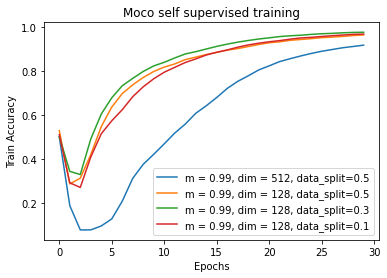

In [10]:
plt.plot(train_10k_99_512_05[:,0],train_10k_99_512_05[:,1],label = "m = 0.99, dim = 512, data_split=0.5")
plt.plot(train_10k_99_128_05[:,0],train_10k_99_128_05[:,1],label= "m = 0.99, dim = 128, data_split=0.5")

plt.plot(train_10k_99_128_03[:,0],train_10k_99_128_03[:,1],label="m = 0.99, dim = 128, data_split=0.3")
plt.plot(train_10k_99_128_01[:,0],train_10k_99_128_01[:,1],label="m = 0.99, dim = 128, data_split=0.1")

plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.legend()
plt.title("Moco self supervised training")

Text(0.5, 1.0, 'Classifier training')

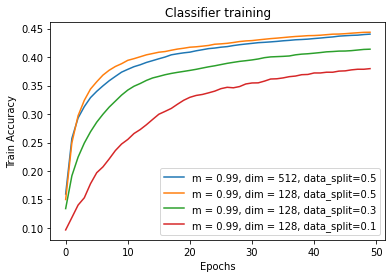

In [12]:
plt.plot(train_linear_10k_99_512_05[:-1,0],train_linear_10k_99_512_05[:-1,1],label = "m = 0.99, dim = 512, data_split=0.5")
plt.plot(train_linear_10k_99_128_05[:-1,0],train_linear_10k_99_128_05[:-1,1],label= "m = 0.99, dim = 128, data_split=0.5")

plt.plot(train_linear_10k_99_128_03[:-1,0],train_linear_10k_99_128_03[:-1,1],label="m = 0.99, dim = 128, data_split=0.3")
plt.plot(train_linear_10k_99_128_01[:-1,0],train_linear_10k_99_128_01[:-1,1],label="m = 0.99, dim = 128, data_split=0.1")

plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.legend()
plt.title("Classifier training")

#### Effect of momentum parameter

Text(0.5, 1.0, 'Moco self supervised training')

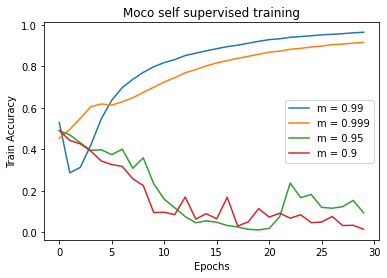

In [14]:
plt.plot(train_10k_99_128_05[:,0],train_10k_99_128_05[:,1],label = "m = 0.99")
plt.plot(train_10k_999_128_05[:,0],train_10k_999_128_05[:,1],label= "m = 0.999")

plt.plot(train_10k_95_128_05[:,0],train_10k_95_128_05[:,1],label="m = 0.95")
plt.plot(train_10k_9_128_05[:,0],train_10k_9_128_05[:,1],label="m = 0.9")

plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.legend()
plt.title("Moco self supervised training")

Text(0.5, 1.0, 'Moco self supervised training')

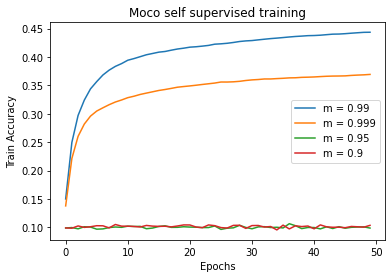

In [16]:
plt.plot(train_linear_10k_99_128_05[:-1,0],train_linear_10k_99_128_05[:-1,1],label = "m = 0.99")
plt.plot(train_linear_10k_999_128_05[:-1,0],train_linear_10k_999_128_05[:-1,1],label= "m = 0.999")

plt.plot(train_linear_10k_95_128_05[:-1,0],train_linear_10k_95_128_05[:-1,1],label="m = 0.95")
plt.plot(train_linear_10k_9_128_05[:-1,0],train_linear_10k_9_128_05[:-1,1],label="m = 0.9")

plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.legend()
plt.title("Classifier training")

#### Effect of Queue size

Text(0.5, 1.0, 'Moco self supervised training')

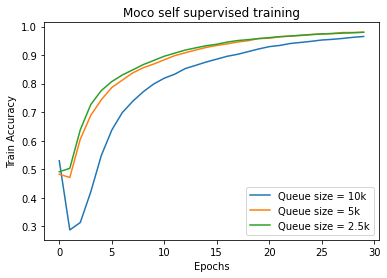

In [18]:
plt.plot(train_10k_99_128_05[:,0],train_10k_99_128_05[:,1],label = "Queue size = 10k")
plt.plot(train_5k_99_128_05[:,0],train_5k_99_128_05[:,1],label= "Queue size = 5k")
plt.plot(train_2k_99_128_01[:,0],train_2k_99_128_01[:,1],label="Queue size = 2.5k")

plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.legend()
plt.title("Moco self supervised training")

Text(0.5, 1.0, 'Classifier training')

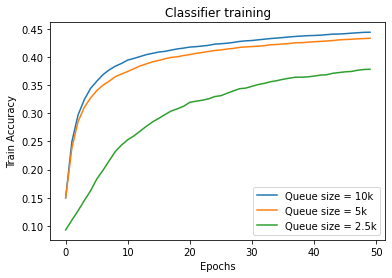

In [20]:
plt.plot(train_linear_10k_99_128_05[:-1,0],train_linear_10k_99_128_05[:-1,1],label = "Queue size = 10k")
plt.plot(train_linear_5k_99_128_05[:-1,0],train_linear_5k_99_128_05[:-1,1],label= "Queue size = 5k")
plt.plot(train_linear_2k_99_128_01[:-1,0],train_linear_2k_99_128_01[:-1,1],label="Queue size = 2.5k")

plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.legend()
plt.title("Classifier training")

#### Result on cifar 10 test set for all setting

In [25]:
pd.DataFrame([[10000,0.99,512,0.5,train_linear_10k_99_512_05[-1,1]],
[10000,0.99,218,0.5,train_linear_10k_99_128_05[-1,1]],
[10000,0.99,218,0.3,train_linear_10k_99_128_03[-1,1]],
[10000,0.99,218,0.1,train_linear_10k_99_128_01[-1,1]],
[10000,0.999,218,0.5,train_linear_10k_999_128_05[-1,1]],
[10000,0.95,218,0.5,train_linear_10k_95_128_05[-1,1]],
[10000,0.9,218,0.5,train_linear_10k_9_128_05[-1,1]],
[5000,0.99,218,0.5,train_linear_5k_99_128_05[-1,1]],
[2500,0.99,218,0.5,train_linear_2k_99_128_01[-1,1]]],
columns = ["Queue size","momentum","Emb_size","datasplit ratio","Test set accuracy"],index=None)             


,Queue size,momentum,Emb_size,datasplit ratio,Test set accuracy
0,10000,0.990,512,0.5,0.422903
1,10000,0.990,218,0.5,0.443771
2,10000,0.990,218,0.3,0.409334
3,10000,0.990,218,0.1,0.369860
4,10000,0.999,218,0.5,0.372327
5,10000,0.950,218,0.5,0.099404
6,10000,0.900,218,0.5,0.100637
7,5000,0.990,218,0.5,0.439453
8,2500,0.990,218,0.5,0.369038
